In [ ]:
%load_ext autoreload
%autoreload 2

import astropy
import galsim
import matplotlib.pyplot as plt
import numpy as np
import scarlet
import sep

import btk
import galcheat.utilities


# SCARLET implementation

This notebook provides a measure function using [SCARLET](https://www.sciencedirect.com/science/article/abs/pii/S2213133718300301), a deblending algorithm based on matrix factorization. **NOTE:** It requires that you install the scarlet python package from the [source](https://github.com/pmelchior/scarlet), the pip installation being outdated. Please follow the instructions for installing scarlet [here](https://pmelchior.github.io/scarlet/install.html). 

This notebook was tested with the version of scarlet corresponding to the tag [`btkv1`](https://github.com/pmelchior/scarlet/releases/tag/btk-v1) found in the scarlet repo. 

If you have not done so already, we encourage you to follow the BTK [intro tutorial](https://lsstdesc.org/BlendingToolKit/tutorials.html), which will help you understand what is done in this notebook.

In [ ]:
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
surveys = btk.survey.get_surveys(["LSST"])

In [ ]:
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    btk.sampling_functions.DefaultSampling(max_number=5,max_shift=6),
    surveys,
    stamp_size=stamp_size,
    batch_size=10,
)

In [ ]:
from scarlet.display import AsinhMapping

def scarlet_measure(batch,idx,channels_last=False,**kwargs):
    """Measure function for SCARLET
    """
    sigma_noise = kwargs.get("sigma_noise", 1.5)    
    surveys = kwargs.get("surveys", None)
    if len(surveys) > 1:
        raise ValueError("Multiresolution is not supported by the SCARLET measure function currently.")
    filters = [surveys[0].get_filter(b) for b in surveys[0].available_filters]
    channel_indx = 0 if not channels_last else -1
    
    #Fist we carry out the detection, using SExtractor (sep being the python implementation)
    # We need to differentiate between the multiresolution and the regular case
    image = batch["blend_images"][idx]
    coadd = np.mean(image, axis=channel_indx)
    psf = np.array([p.drawImage(galsim.Image(image.shape[1],image.shape[2]),scale=surveys[0].pixel_scale.to_value("arcsec")).array for p in batch["psf"]])
    wcs_ref = batch["wcs"]
    multiresolution = False

    bkg = sep.Background(coadd)
    catalog, segmentation = sep.extract(
        coadd, sigma_noise, err=bkg.globalrms, segmentation_map=True
    )

    # If there is no detections
    if len(catalog) == 0:
        t = astropy.table.Table()
        t["ra"], t["dec"] = wcs_ref.pixel_to_world_values(catalog["x"], catalog["y"])
        t["ra"], t["dec"] = t["ra"]*3600,t["dec"]*3600
        if multiresolution:
            return {"catalog":t,"segmentation":None,"deblended_images":{s.name: np.array([np.zeros((len(s.available_filters),batch["blend_images"][s.name][idx].shape[1],
                                                batch["blend_images"][s.name][idx].shape[1]))]) for s in surveys}}
        else:
            s = surveys[0]
            return {"catalog":t,"segmentation":None,"deblended_images":np.array([np.zeros((len(s.available_filters),batch["blend_images"][idx].shape[1],
                                                batch["blend_images"][idx].shape[1]))])}
    
    ### Initializing scarlet ###
    bands = surveys[0].available_filters
    
    model_psf = scarlet.GaussianPSF(sigma=(0.6,)*len(filters))

    model_frame = scarlet.Frame(
        image.shape,
        psf=model_psf,
        channels=bands,
        wcs=wcs_ref)

    observations = [scarlet.Observation(
        image,
        psf=scarlet.ImagePSF(psf),
        weights=np.ones(image.shape)/ (bkg.globalrms**2),
        channels=bands,
        wcs=wcs_ref).match(model_frame)]
    
    ra_dec = np.array(wcs_ref.pixel_to_world_values(catalog["x"],catalog["y"])).T
    # We define a source for each detection
    sources = [scarlet.ExtendedSource(model_frame,
                                      sky_coord,
                                      observations,
                                      thresh=0.1) for sky_coord in ra_dec]
    scarlet.initialization.set_spectra_to_match(sources, observations)

    t = astropy.table.Table()
    ### Fitting the sources to the blend ###
    try:
        blend = scarlet.Blend(sources, observations)
        blend.fit(200, e_rel=1e-5)
 
        ### Returning the results in a BTK compatible form ###
        deblended_images = {}
        for i in range(len(surveys)):
            im, selected_peaks = [], []
            for k, component in enumerate(sources):
                y, x = component.center
                selected_peaks.append([x, y])
                model = component.get_model(frame=model_frame)
                model_ = observations[i].render(model)
                model_ = np.transpose(model_, axes=(1, 2, 0)) if channels_last else model_
                im.append(model_)
            selected_peaks = np.array(selected_peaks)
            deblended_images[surveys[i].name] = np.array(im)
        sky_coords = wcs_ref.pixel_to_world_values(catalog["x"], catalog["y"])
        t["ra"], t["dec"] = sky_coords
        
    except AssertionError: # If the fitting fails, return empty images
        t["ra"], t["dec"] = wcs_ref.pixel_to_world_values(catalog["x"], catalog["y"])
        if multiresolution:
            deblended_images={s.name: np.array([np.zeros((len(s.filters),batch["blend_images"][s.name][idx].shape[1],
                                              batch["blend_images"][s.name][idx].shape[1])) for c in catalog]) for s in surveys}
        else:
            deblended_images={s.name: np.array([np.zeros((len(s.filters),batch["blend_images"][idx].shape[1],
                                              batch["blend_images"][idx].shape[1])) for c in catalog]) for s in surveys}
        print("failed")
    
    if len(surveys) == 1:
        deblended_images = deblended_images[surveys[0].name]
    t["ra"], t["dec"] = t["ra"]*3600,t["dec"]*3600
    return {"catalog":t,"segmentation":None,"deblended_images":deblended_images}

In [ ]:
measure_kwargs=[{"sigma_noise": 2.0}]
meas_generator = btk.measure.MeasureGenerator(
    [btk.measure.sep_singleband_measure,scarlet_measure], draw_blend_generator, measure_kwargs=measure_kwargs
)
metrics_generator = btk.metrics.MetricsGenerator(
    meas_generator,
    target_meas={"ellipticity": btk.metrics.meas_ksb_ellipticity},
    meas_band_name="r"
)

In [ ]:
blend_results,measure_results,metrics_results = next(metrics_generator)

Generating blends for LSST survey:   0%|          | 0/100 [00:00<?, ?it/s]

# Plot Metrics from Scarlet Results

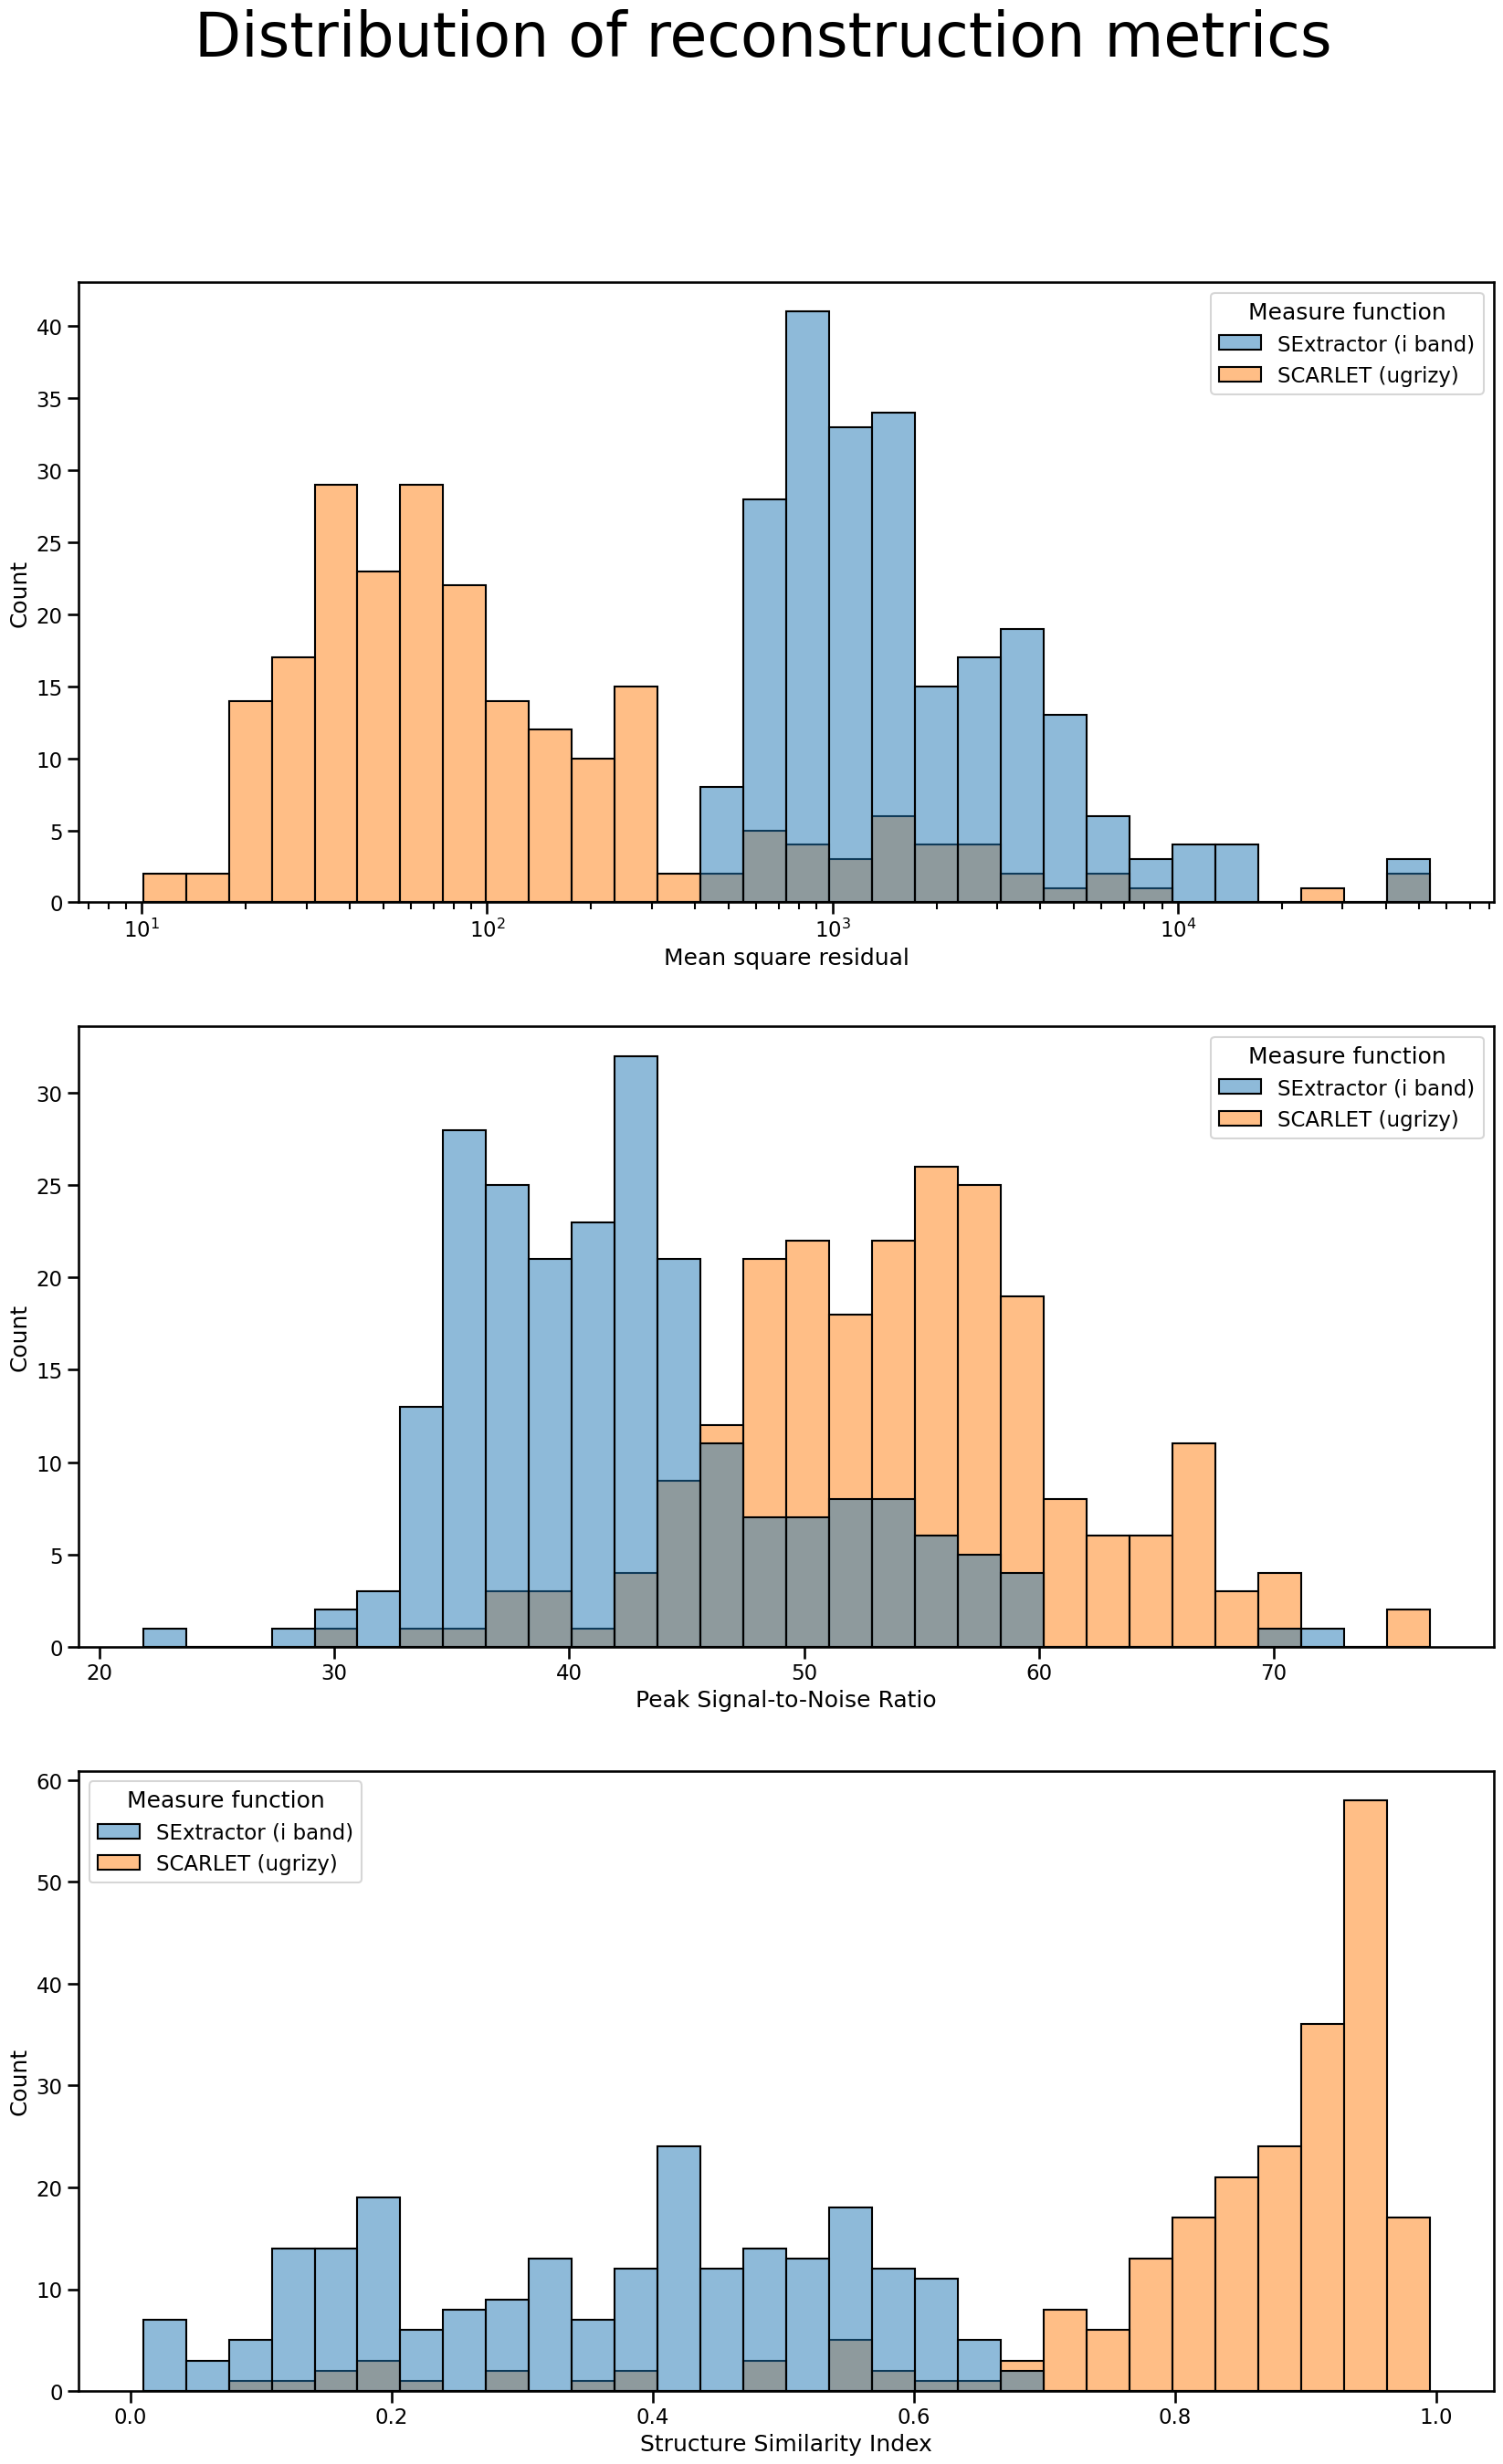

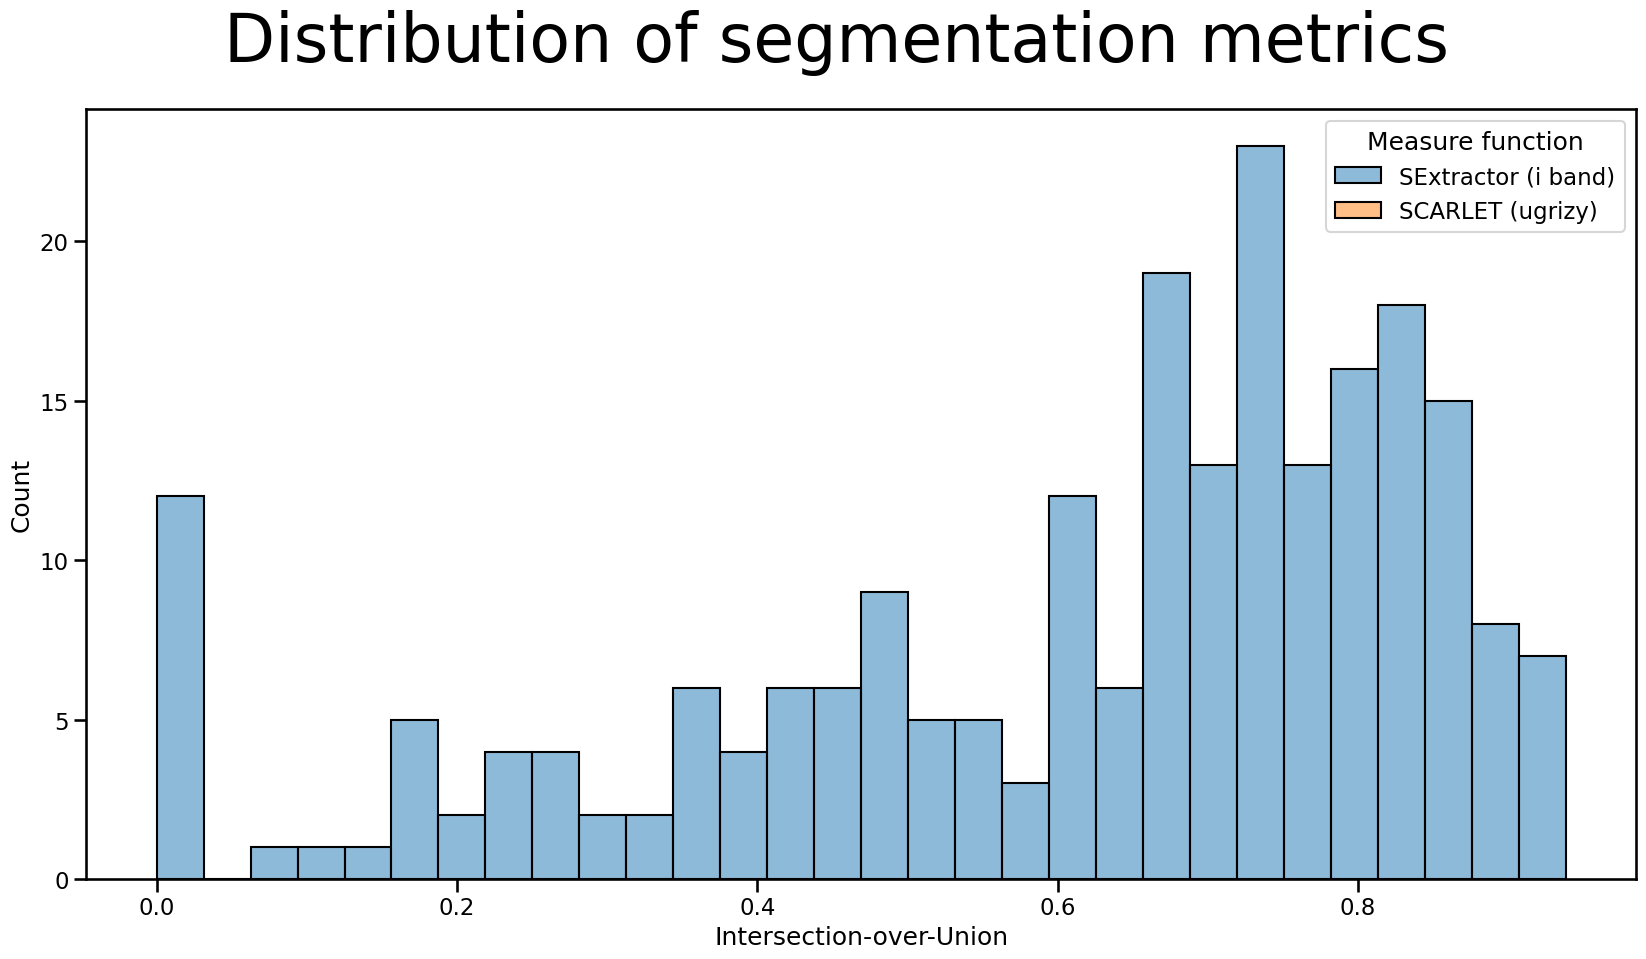

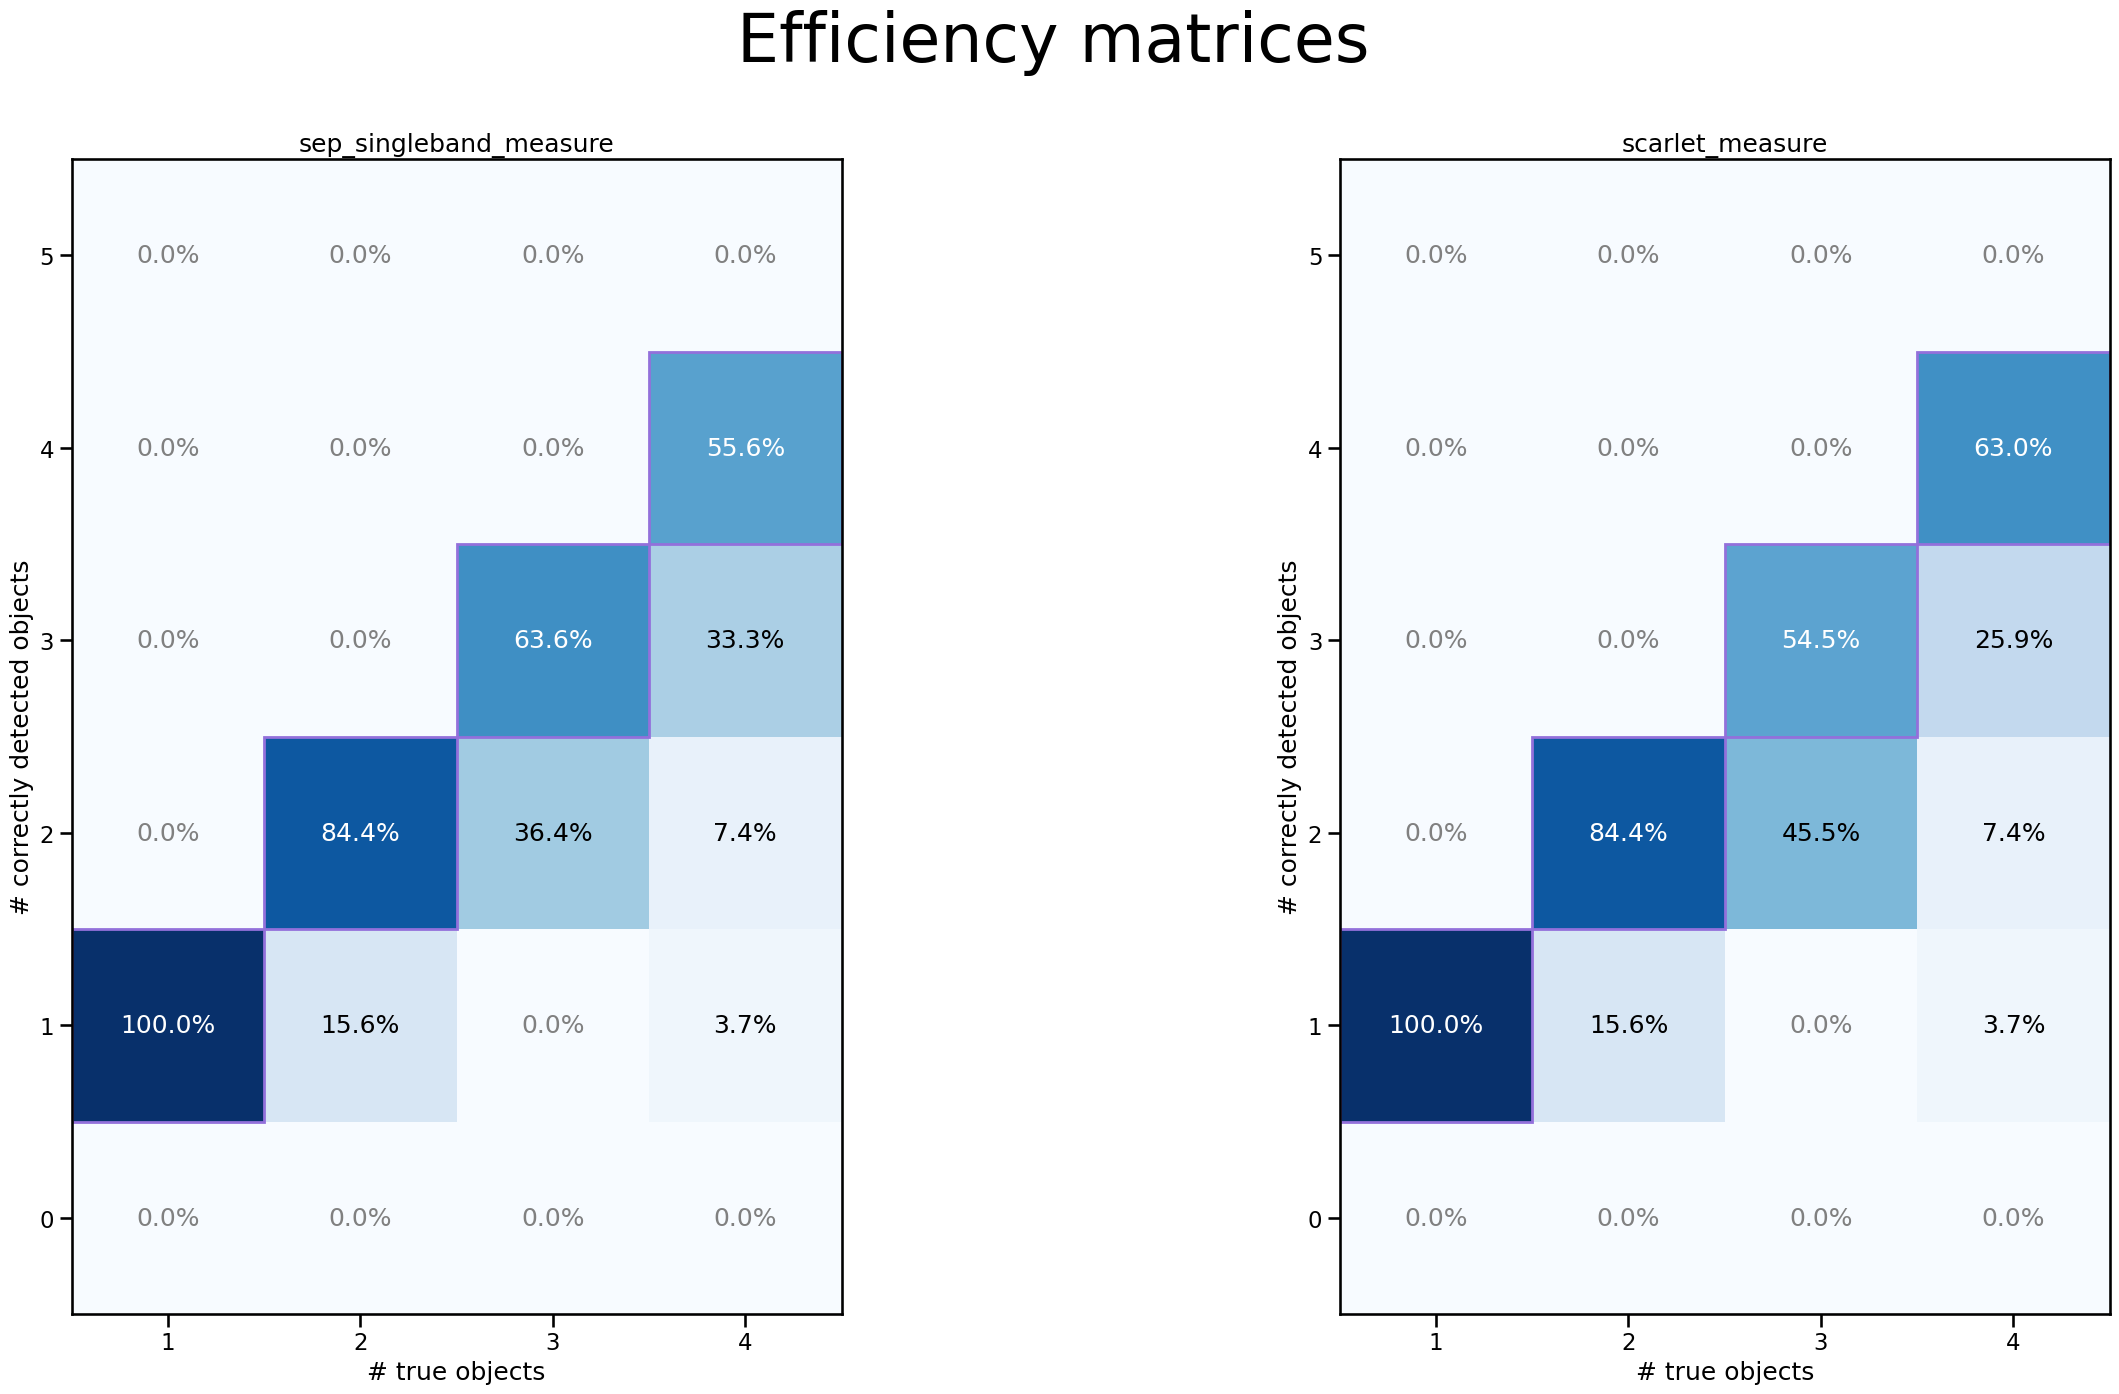

In [ ]:
btk.plot_utils.plot_metrics_summary(metrics_results,interactive=False,
                                    aliases={"measure_function":"Measure function",
                                            "sep_singleband_measure":"SExtractor (i band)",
                                            "scarlet_measure":"SCARLET (ugrizy)"})

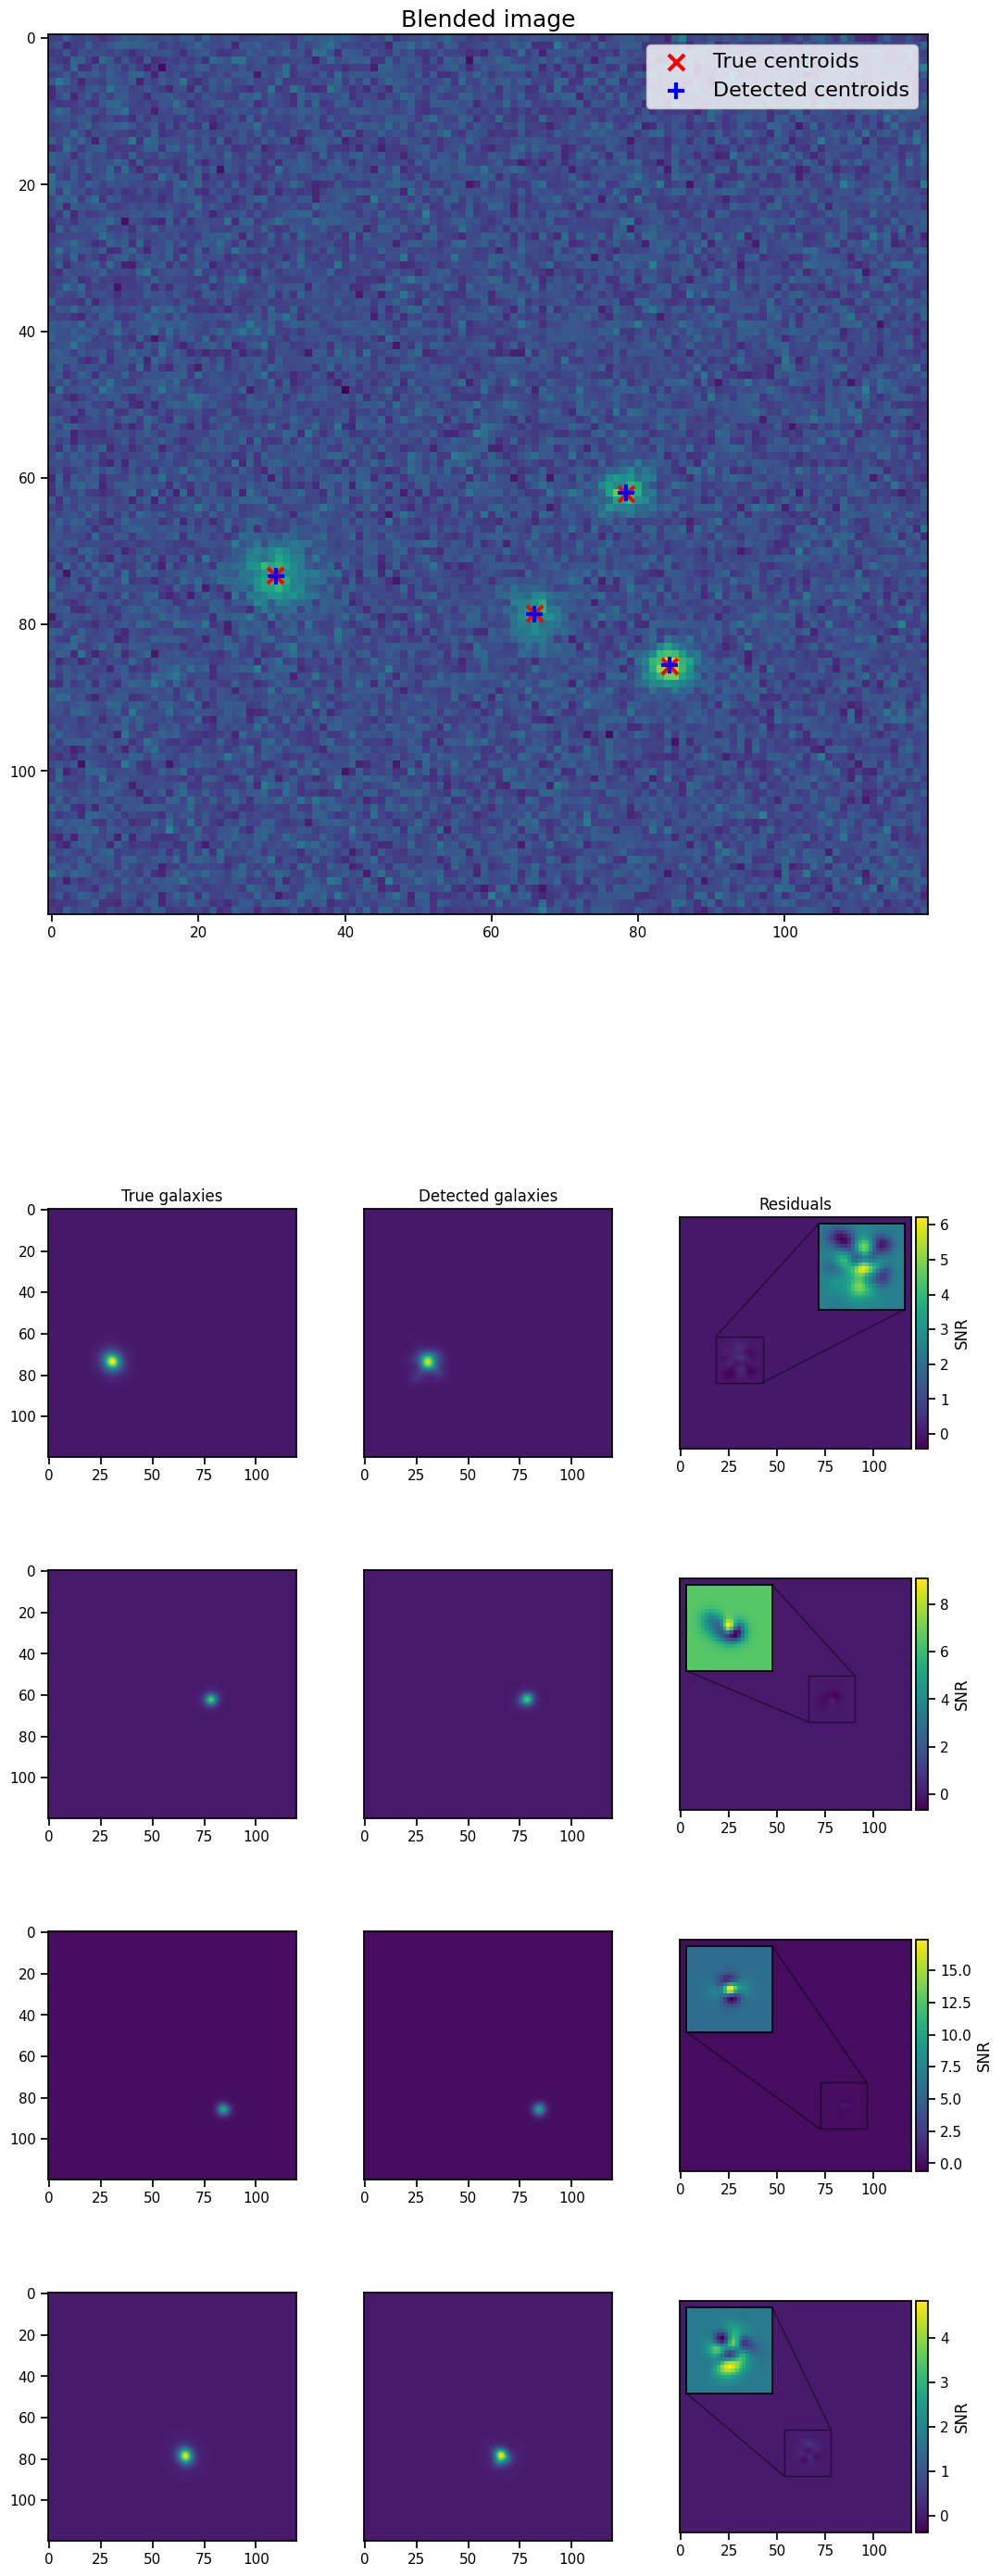

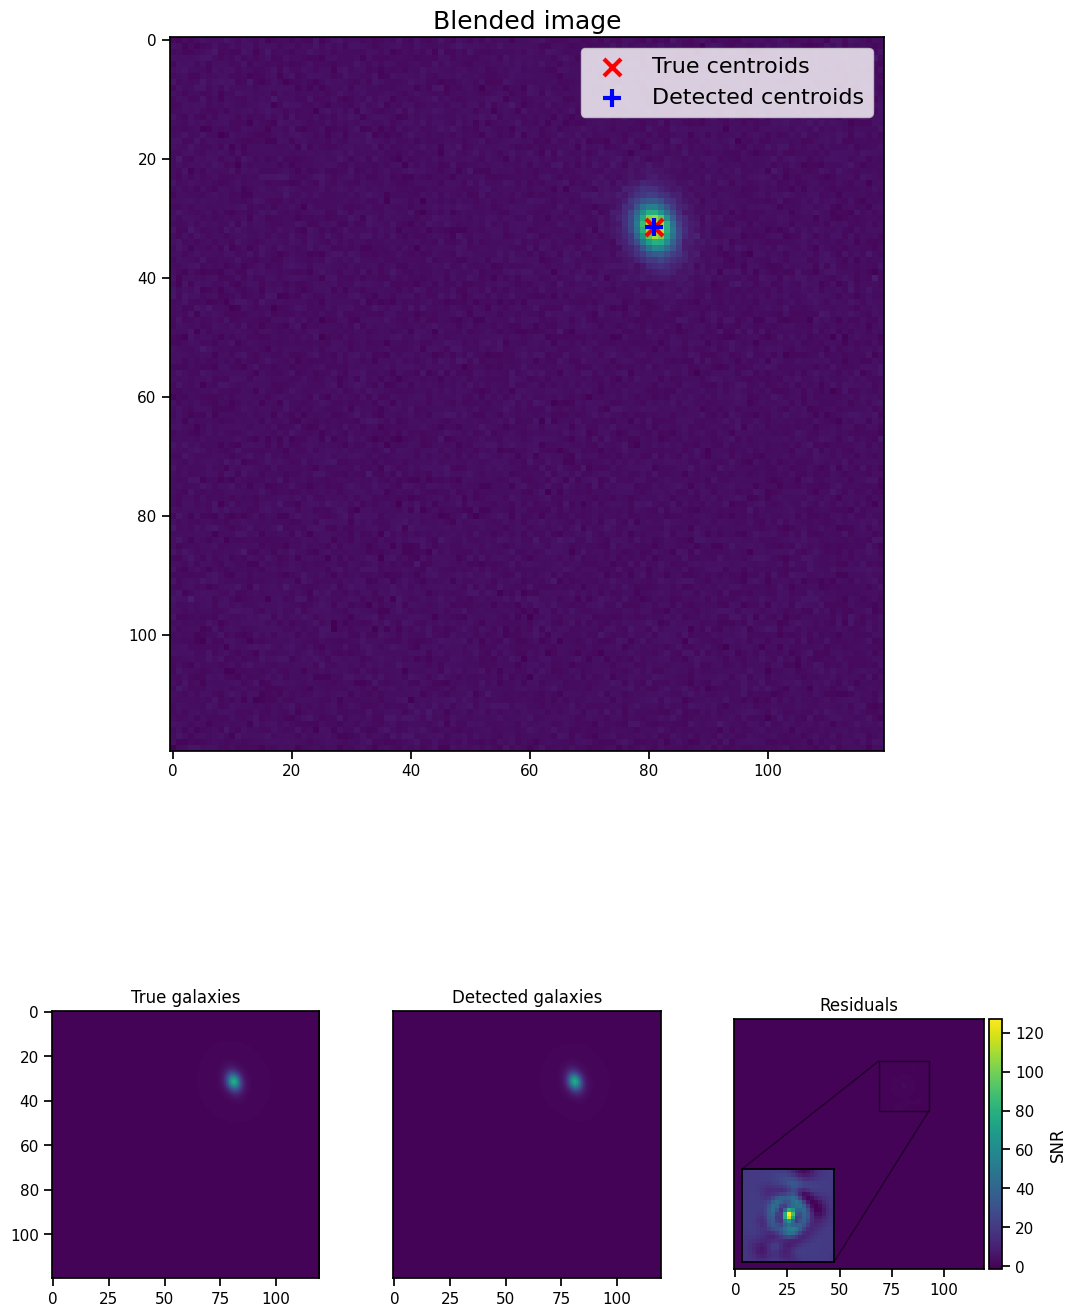

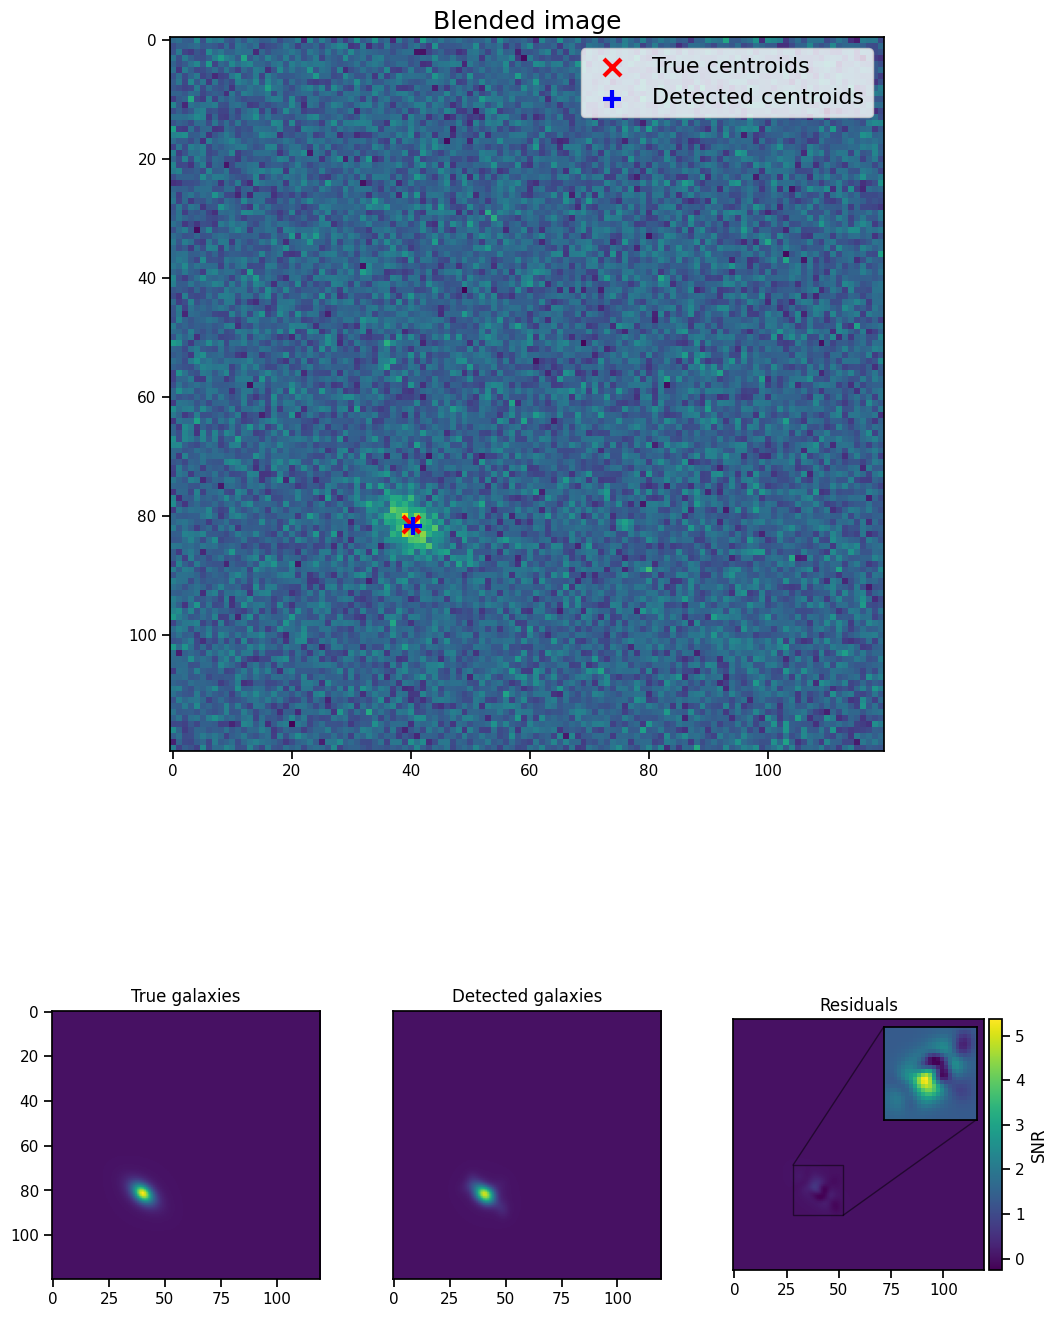

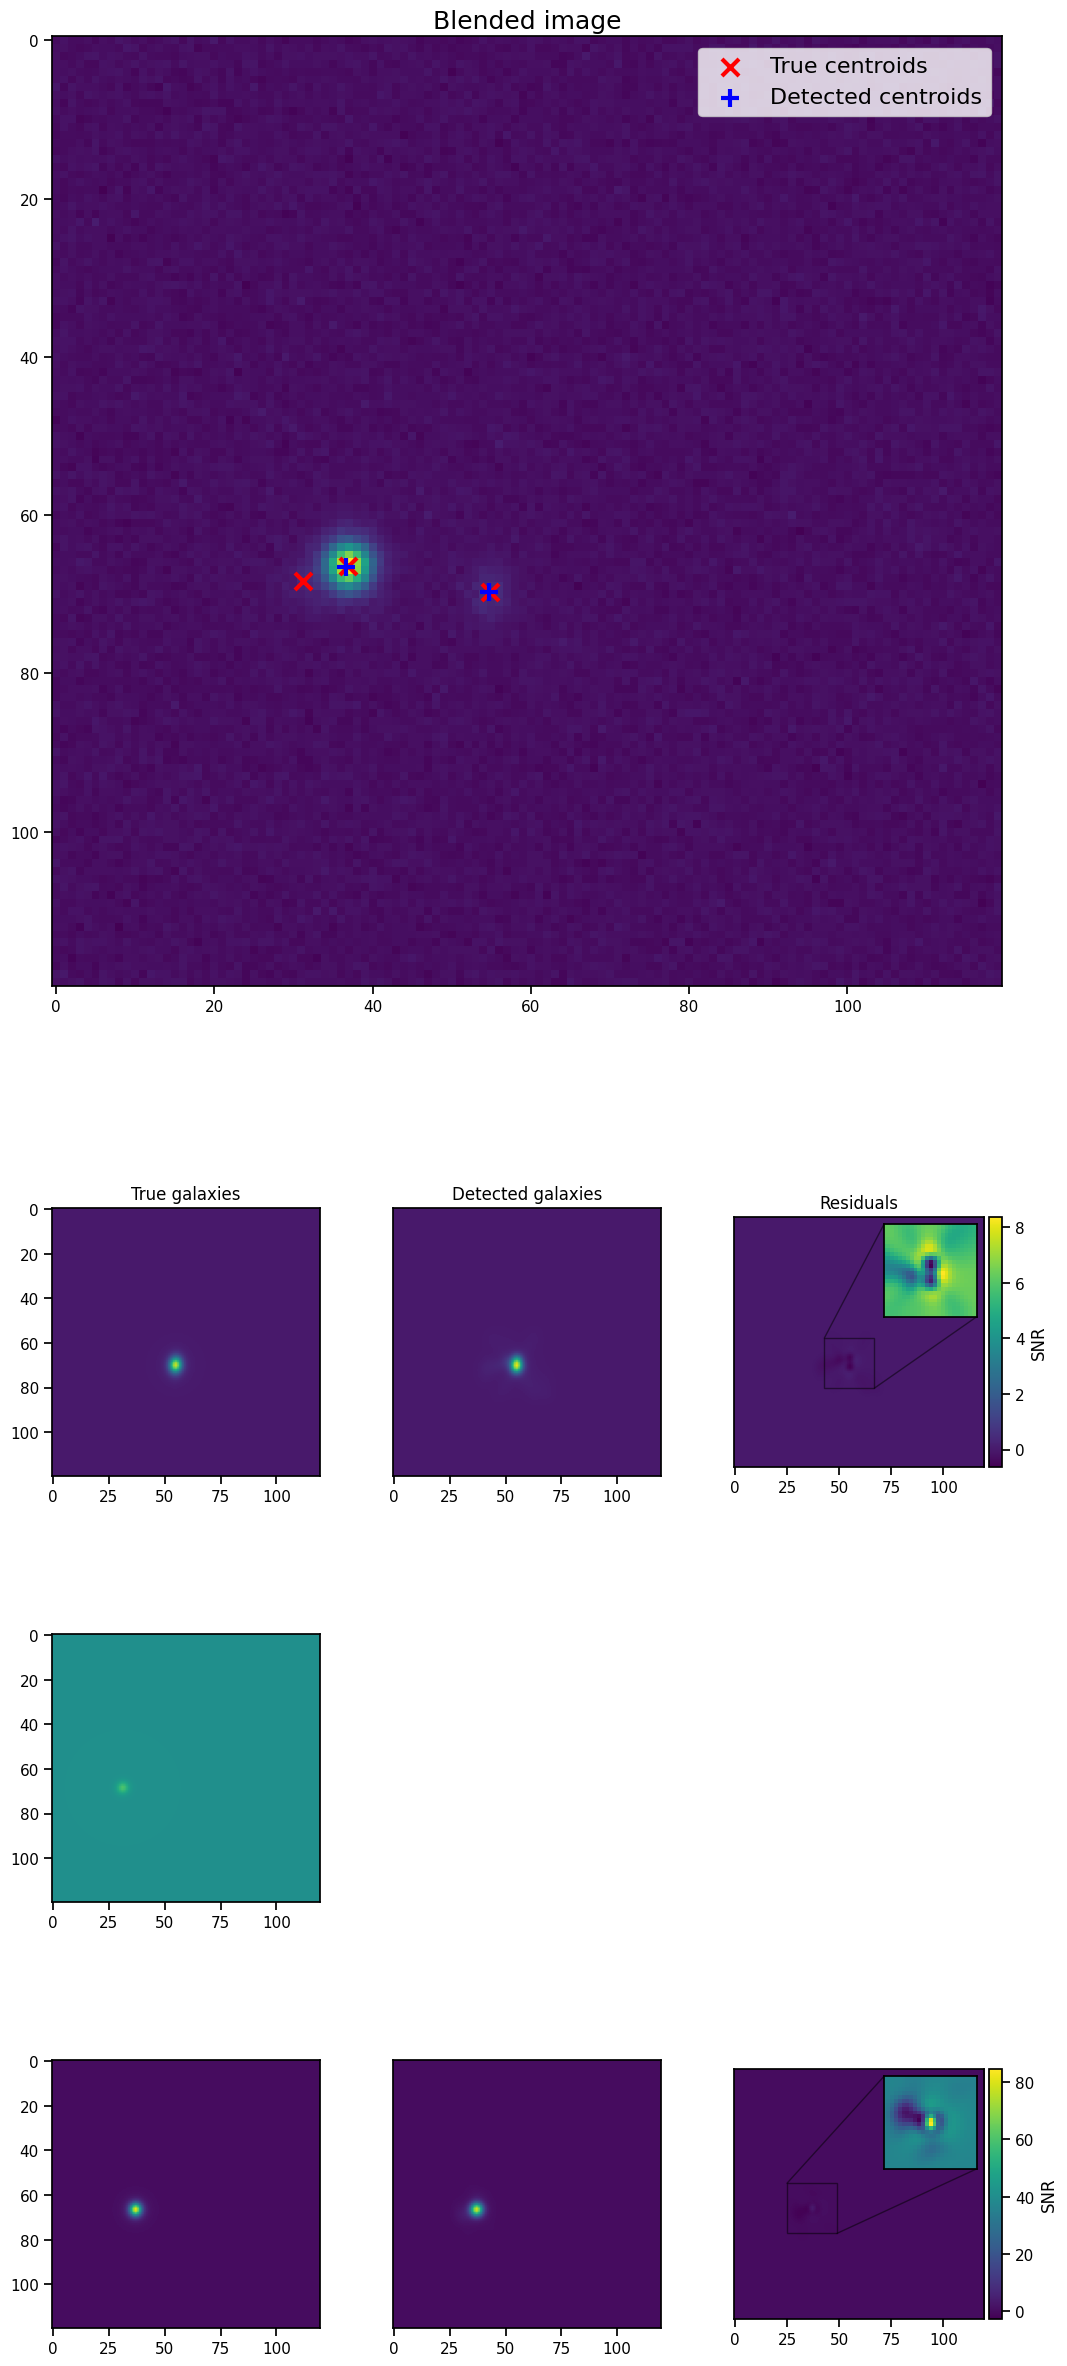

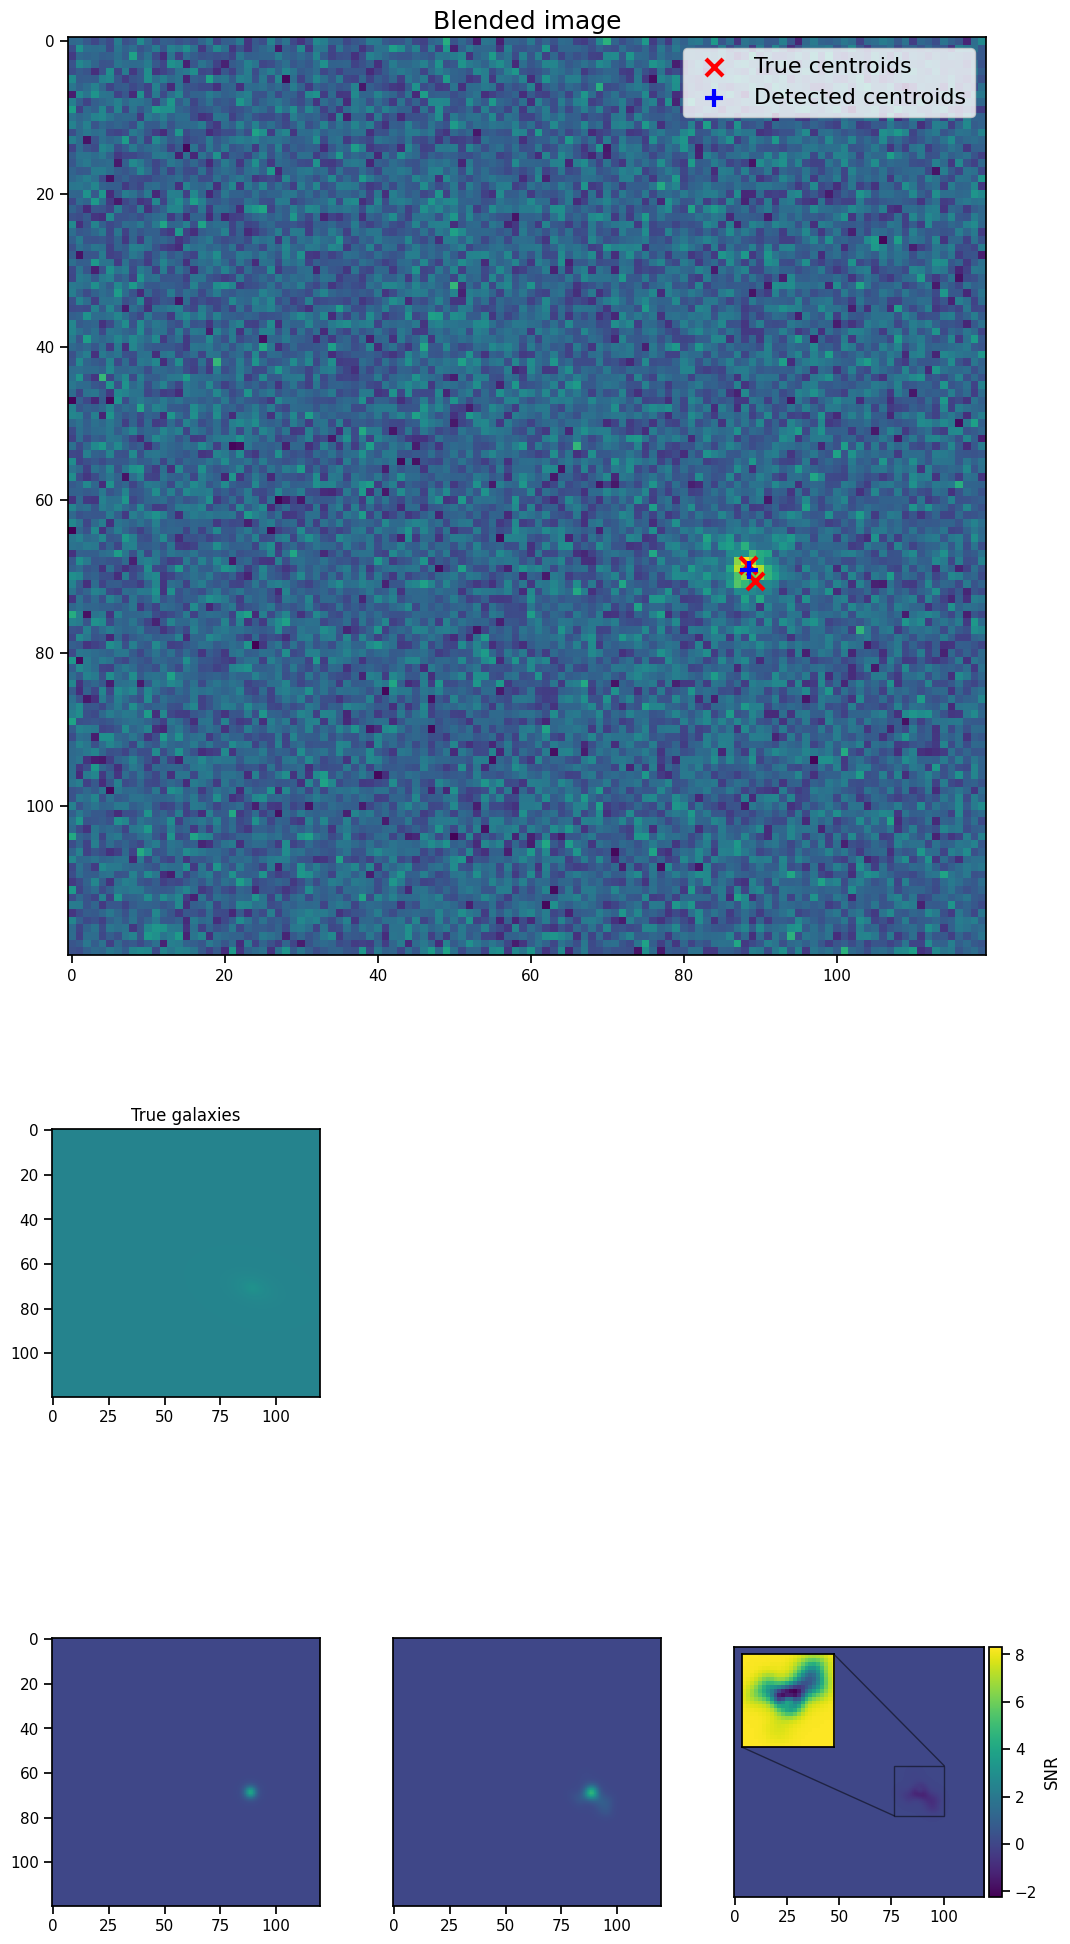

In [ ]:
btk.plot_utils.plot_with_deblended(
    blend_results["blend_images"],
    blend_results["isolated_images"],
    blend_results["blend_list"],
    measure_results["catalog"]["scarlet_measure"],
    measure_results["deblended_images"]["scarlet_measure"],
    metrics_results["matches"]["scarlet_measure"],
    indexes=list(range(5)),
    band_indices=[2],
    noise_level=np.sqrt(galcheat.utilities.mean_sky_level(surveys, surveys.get_filter("i")).to_value("electron"))
)